# Imports

In [1]:
%%capture
%pip install datasets
%pip install torch torchvision torchaudio
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install scikit-image[data]
%pip install matplotlib

In [2]:
import random

import  torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import skimage.transform as sk

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datasets

/users/eleves-b/2024/duc-anh.nguyen/AI/mathwriting/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare dataset

## Save dataset

In [ ]:
# !unzip images.zip -d images
# # load datasets

# np.set_printoptions(threshold=np.inf)

# pf = pandas.read_csv('dataset.csv')

# train = []
# test = []
# label_dict = dict()

# for i, row in pf.iterrows():
#     im = iio.imread('images/' + row['image'])
#     tmp = np.ndarray(shape=(len(im), len(im[0])), dtype=np.float64)
#     for i in range(len(im)):
#         for j in range(len(im[i])):
#             s = 0
#             for c in im[i][j]:
#                 s += int(c)
#             tmp[i][j] = (1 if s < 255 else 0)
#     input = torch.tensor(tmp, dtype=torch.float64)
#     label = row['label']
#     if label not in label_dict:
#         label_dict[label] = len(label_dict)
#         label = label_dict[label]
#         test.append((input, label))
#     else:
#         label = label_dict[label]
#         train.append((input, label))
# for i in range(len(train)):
#     train[i] = {'input': train[i][0], 'label': train[i][1]}

# for i in range(len(test)):
#     test[i] = {'input': test[i][0], 'label': test[i][1]}

# datasets.DatasetDict({
#     'train': datasets.Dataset.from_list(train),
#     'test': datasets.Dataset.from_list(test)
# }).save_to_disk('dataset')

# !zip -r dataset.zip dataset

In [ ]:
# pf = pandas.read_csv('dataset.csv')
# label_set = set()
# label_list = []

# for lb in pf.label:
#     if lb not in label_set:
#         label_set.add(lb)
#         label_list.append(lb)

# pandas.DataFrame(label_list).to_csv('labels.csv')

# Load dataset

In [3]:
ddata = pd.read_csv("dataset.csv")
labels = pd.read_csv("labels.csv")
ds = datasets.load_from_disk('dataset')

# Resize images

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]



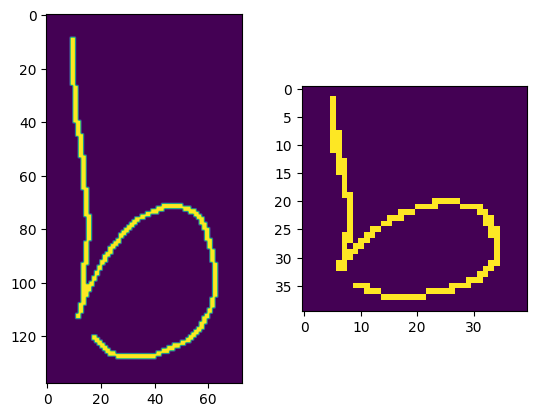

In [4]:
n = 0
grid = np.array(ds['train'][n]['input'])
# Target size
new_shape = (40, 40)

# Resize with anti-aliasing
resized_grid = sk.resize(grid, new_shape, mode='reflect', anti_aliasing=True)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(grid)
axs[1].imshow(resized_grid > 0.25)
# plt.show()

print(resized_grid)

print(np.array(''))

In [17]:
image_size = 40

new_shape = (image_size, image_size)

def scale_input(data):
    input, output = data['input'], data['label']
    input = sk.resize(np.array(input), new_shape, mode='reflect', anti_aliasing=True)
    return {'input': input, 'label': output}

train = [scale_input(ds['train'][i]) for i in range(len(ds['train']))]
test = [scale_input(ds['test'][i]) for i in range(len(ds['test']))]

In [18]:
def print_image(data, out = None):
    for i, r in enumerate(data):
        for x in r:
            if x < 0.2: print(' ', end='', file=out)
            elif x < 0.4: print('.', end='', file=out)
            elif x < 0.6: print('o', end='', file=out)
            elif x < 0.8: print('O', end='', file=out)
            else: print('@', end='', file=out)
        print('', file=out)

print(test[0]['input'])
print_image(test[0]['input'])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
                                        
                                        
                                        
                                        
                                        
        o@@o                            
        o@@o                            
        o@@                             
        o@@                             
        o@@                             
        o@@                             
        o@@                             
        o@@o                            
        o@@.                            
        o@@                             
        o@@                             
        o@@                             
        o@@                             
        o@@o                            
        o@@o                            
        o@@o            

# Train

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
input_channels = 1  # 1 for grayscale, 3 for RGB
hidden_size = 512
output_size = 229
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)  # (40x40) -> (40x40)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # (40x40) -> (40x40)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # (40x40) -> (20x20)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # (20x20) -> (20x20)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (20x20) -> (10x10)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 10 * 10, hidden_size)  # Flattened size
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = torch.relu(self.conv3(x))  # Conv3 -> ReLU
        x = self.pool2(x)  # Pooling after Conv3
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))  # Fully connected
        x = self.fc2(x)  # Output layer
        return x

# Initialize model
model = CNN(input_channels, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare dataset (reshape to 40x40 for CNN)
X_train = torch.stack([torch.tensor(data['input'], dtype=torch.float32).reshape(1, image_size, image_size) for data in train]).to(device)
y_train = torch.tensor([data['label'] for data in train], dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_test = torch.stack([torch.tensor(data['input'], dtype=torch.float32).reshape(1, image_size, image_size) for data in test]).to(device)
y_test = torch.tensor([data['label'] for data in test], dtype=torch.long).to(device)

out = open('output.txt', 'w')

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = len(test)
        sum_loss = 0

        for i in range(total):
            output = model(X_test[i].unsqueeze(0))  # Add batch dimension
            predicted = torch.argmax(output, dim=1).item()

            if predicted == y_test[i].item():
                correct += 1
            else:
                print('```', file=out)
                print_image(test[i]['input'], out)
                print('```', file=out)
                print(f"Predicted: {predicted} - ${labels.get('0').values[predicted]}{{}}{{}}{{}}{{}}$", file=out)
                print(f"True: {y_test[i].item()} - ${labels.get('0').values[y_test[i].item()]}{{}}{{}}{{}}{{}}$", file=out)
                print('', file=out)

            sum_loss += criterion(output, y_test[i].unsqueeze(0)).item()

        avg_loss = sum_loss / total
        accuracy = correct / total

        print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}", file=out)

Epoch [1/10], Step [1/101], Loss: 5.4365
Epoch [1/10], Step [101/101], Loss: 2.0393
Epoch 1: Average Loss: 3.5264, Accuracy: 0.2576
Epoch [2/10], Step [1/101], Loss: 2.9657
Epoch [2/10], Step [101/101], Loss: 0.0241
Epoch 2: Average Loss: 2.2369, Accuracy: 0.4541
Epoch [3/10], Step [1/101], Loss: 1.3866
Epoch [3/10], Step [101/101], Loss: 3.6134
Epoch 3: Average Loss: 1.9393, Accuracy: 0.5328
Epoch [4/10], Step [1/101], Loss: 1.1303
Epoch [4/10], Step [101/101], Loss: 0.1034
Epoch 4: Average Loss: 1.6108, Accuracy: 0.5721
Epoch [5/10], Step [1/101], Loss: 0.8078
Epoch [5/10], Step [101/101], Loss: 2.8742
Epoch 5: Average Loss: 1.7147, Accuracy: 0.5502
Epoch [6/10], Step [1/101], Loss: 0.5055
Epoch [6/10], Step [101/101], Loss: 0.0134
Epoch 6: Average Loss: 1.7522, Accuracy: 0.5590
Epoch [7/10], Step [1/101], Loss: 0.5328
Epoch [7/10], Step [101/101], Loss: 1.4224
Epoch 7: Average Loss: 1.7829, Accuracy: 0.5764
Epoch [8/10], Step [1/101], Loss: 0.1610
Epoch [8/10], Step [101/101], Loss: